# Implementacja

#### Import bibliotek

In [125]:
import numpy as np
import pandas as pd
from anytree import Node, RenderTree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import _tree
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from rich.tree import Tree as RichTree
from rich import print
from IPython.display import clear_output
from rich.console import Console
import json
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

#### Implementacja drzewa

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from IPython.display import clear_output
from rich.console import Console
from rich.tree import Tree as RichTree
import numpy as np


class CustomDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=None, similarity_threshold=0.01, preference_list=None,
                 interactive=False, interactive_threshold=0.01, random_state=None, min_samples_split=2):
        self.max_depth = max_depth
        self.similarity_threshold = similarity_threshold
        self.preference_list = preference_list or []
        self.interactive = interactive
        self.interactive_threshold = interactive_threshold
        self.random_state = random_state
        self.min_samples_split = min_samples_split
        self.tree_ = None
        self.console = Console()

    def _calculate_split_quality(self, X, y, feature_index):
        values = X[:, feature_index]
        unique_values = np.unique(values)
        splits = [y[values == val] for val in unique_values]
        weighted_gini = sum(len(s) / len(y) * (1 - sum((np.mean(s == c) ** 2 for c in np.unique(s)))) for s in splits)
        return -weighted_gini

    def _choose_split(self, qualities, highlight_path):
        best_quality = qualities[0][1]
        candidates = [q for q in qualities if abs(q[1] - best_quality) <= self.similarity_threshold]

        if self.interactive and abs(candidates[0][1] - candidates[-1][1]) <= self.interactive_threshold:
            clear_output(wait=True)
            self.console.print("[bold cyan]Aktualne drzewo (➤ podświetlony węzeł):[/bold cyan]")
            self.console.print(self.to_rich(self.tree_, highlight_path=highlight_path))

            self.console.print("\n[bold yellow]Zbliżona jakość cech. Wybierz jedną:[/bold yellow]")
            for idx, (f, q) in enumerate(candidates):
                self.console.print(f"[bold blue]{idx}[/bold blue]: Cecha [cyan]{f}[/cyan] (Jakość: [green]{q:.4f}[/green])")

            try:
                choice = int(input("🧠 Wybierz indeks cechy: "))
                if choice < 0 or choice >= len(candidates):
                    print("❗ Niepoprawny wybór, używam pierwszego kandydata.")
                    choice = 0
            except ValueError:
                print("❗ Błąd wejścia, używam pierwszego kandydata.")
                choice = 0
            return candidates[choice][0]

        if self.preference_list:
            candidate_features = {f for f, _ in candidates}
            for preferred in self.preference_list:
                if preferred in candidate_features:
                    return preferred

        return candidates[0][0]

    def _build_tree(self, X, y, depth=0, used_features=None, path=None, parent=None, val_from_parent=None):
        if used_features is None:
            used_features = set()
        if path is None:
            path = []

        # warunki zakończenia
        if (self.max_depth is not None and depth >= self.max_depth) or len(set(y)) == 1 or \
        len(y) < self.min_samples_split or len(used_features) == X.shape[1]:
            leaf = {
                'type': 'leaf',
                'class': np.bincount(y).argmax(),
                'label_counts': np.bincount(y, minlength=2)
            }
            if parent is not None and val_from_parent is not None:
                parent['branches'][val_from_parent] = leaf
            return leaf

        # oblicz jakość cech
        qualities = [
            (i, self._calculate_split_quality(X, y, i))
            for i in range(X.shape[1]) if i not in used_features
        ]
        if not qualities:
            leaf = {
                'type': 'leaf',
                'class': np.bincount(y).argmax(),
                'label_counts': np.bincount(y, minlength=2)
            }
            if parent is not None and val_from_parent is not None:
                parent['branches'][val_from_parent] = leaf
            return leaf

        qualities.sort(key=lambda x: -x[1])
        feature = self._choose_split(qualities, path)
        new_used_features = used_features.copy()
        new_used_features.add(feature)
        default_class = np.bincount(y).argmax()

        node = {'type': 'split', 'feature': feature, 'branches': {}, 'default_class': default_class}

        # podłącz node do parenta, jeśli to nie root
        if parent is not None and val_from_parent is not None:
            parent['branches'][val_from_parent] = node
        else:
            self.tree_ = node  # to jest root

        values = np.unique(X[:, feature])
        for val in values:
            idx = X[:, feature] == val
            if np.sum(idx) == 0:
                continue

            # Wstaw tymczasowy znacznik
            node['branches'][val] = {'type': 'pending'}

            # Interaktywny podgląd całego drzewa
            if self.interactive:
                clear_output(wait=True)
                rich_tree = self.to_rich(self.tree_, highlight_path=path + [(feature, val)])
                self.console.print("[bold cyan]Aktualne drzewo (➤ budowany węzeł):[/bold cyan]")
                self.console.print(rich_tree)
                self.last_rich = rich_tree

            # Rekurencja z referencją do rodzica
            self._build_tree(
                X[idx], y[idx],
                depth=depth + 1,
                used_features=new_used_features,
                path=path + [(feature, val)],
                parent=node,
                val_from_parent=val
            )

        # jeśli nadal puste — zrób liść
        if not node['branches']:
            return {
                'type': 'leaf',
                'class': default_class,
                'label_counts': np.bincount(y, minlength=2)
            }

        return node


    def fit(self, X, y):
        X_arr, y_arr = np.array(X), np.array(y)
        self.tree_ = self._build_tree(X_arr, y_arr)
        clear_output(wait=True)
        return self

    def _predict_sample(self, x, node):
        if node['type'] == 'leaf':
            return node['class']
        val = x[node['feature']]
        branch = node['branches'].get(val)
        if branch is None:
            return node.get('default_class', 0)
        return self._predict_sample(x, branch)

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree_) for x in X.to_numpy()])

    def predict_proba(self, X):
        def _predict_proba_sample(x, node):
            if node['type'] == 'leaf':
                counts = np.zeros(2)
                total = sum(node.get('label_counts', [0]))
                if total > 0:
                    counts[:len(node['label_counts'])] = node['label_counts']
                    return counts / total
                else:
                    return np.array([0.5, 0.5])
            val = x[node['feature']]
            branch = node['branches'].get(val)
            if branch is None:
                return np.array([0.5, 0.5])
            return _predict_proba_sample(x, branch)

        return np.array([_predict_proba_sample(x, self.tree_) for x in X.to_numpy()])

    def to_rich(self, node=None, highlight_path=None):
        if node is None:
            node = self.tree_
        if highlight_path is None:
            highlight_path = []

        def build_tree(node, path_so_far):
            if node is None:
                return RichTree("[red]⛔ Brak danych[/red]")

            is_highlight = path_so_far == highlight_path

            if node.get('type') == 'pending':
                label = "[magenta]⏳ Budowanie...[/magenta]"
                if is_highlight:
                    label = f"[bold red]➤ {label}[/bold red]"
                return RichTree(label)

            if node['type'] == 'leaf':
                label = f"[green]Klasa: {node['class']}[/green]"
                if is_highlight:
                    label = f"[bold red]➤ {label}[/bold red]"
                return RichTree(label)

            label = f"[cyan]Cecha {node['feature']}[/cyan]"
            if is_highlight:
                label = f"[bold red]➤ {label}[/bold red]"
            tree = RichTree(label)

            for val, child in node['branches'].items():
                new_path = path_so_far + [(node['feature'], val)]
                branch_label = f"[yellow]Wartość = {val}[/yellow]"
                subtree = build_tree(child, new_path)
                tree.add(branch_label).children.append(subtree)
            return tree

        return build_tree(node, [])


#### Evaluate model

In [127]:
def train_and_evaluate_model(model, X, y, target_names=None, test_size=0.2, random_state=42):
    # Data split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Fit model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average='macro')
    f1_micro = f1_score(y_val, y_pred, average='micro')
    cm = confusion_matrix(y_val, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (macro): {f1_macro:.4f}")
    print(f"F1 Score (micro): {f1_micro:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Confusion Matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # ROC + AUC only for binary classification
    if len(np.unique(y_val)) == 2:
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_val)[:, 1]
        else:
            try:
                y_scores = model.decision_function(X_val)
            except:
                print("Model does not support decision function or predict_proba.")
                return

        fpr, tpr, _ = roc_curve(y_val, y_scores)
        roc_auc = auc(fpr, tpr)
        
        print(f"AUC: {roc_auc:.4f}")
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
        plt.title("ROC Curve")
        plt.show()
    else:
        print("ROC + AUC only for binary classification.")
    
    return model

def evaluate_model(model, X, y, target_names=None):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1_macro = f1_score(y, y_pred, average='macro')
    f1_micro = f1_score(y, y_pred, average='micro')
    cm = confusion_matrix(y, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (macro): {f1_macro:.4f}")
    print(f"F1 Score (micro): {f1_micro:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Confusion Matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

#### Przykład wywołania (preferencje)

Accuracy: 0.9618

F1 Score (macro): 0.9618

F1 Score (micro): 0.9618

Confusion Matrix:
[[816  26]
 [ 36 747]]

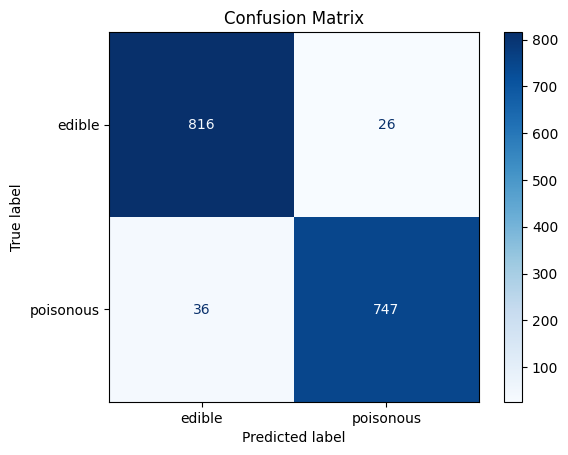

AUC: 0.9933

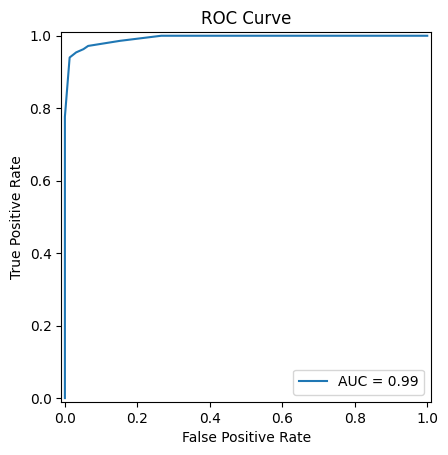

➤ Cecha 21
├── Wartość = 0
│   └── Cecha 20
│       ├── Wartość = 1
│       │   └── Klasa: 1
│       ├── Wartość = 3
│       │   └── Klasa: 1
│       ├── Wartość = 4
│       │   └── Cecha 19
│       │       ├── Wartość = 1
│       │       │   └── Cecha 18
│       │       │       ├── Wartość = 1
│       │       │       │   └── Klasa: 0
│       │       │       └── Wartość = 2
│       │       │           └── Klasa: 1
│       │       ├── Wartość = 2
│       │       │   └── Cecha 18
│       │       │       └── Wartość = 4
│       │       │           └── Klasa: 0
│       │       ├── Wartość = 3
│       │       │   └── Cecha 18
│       │       │       └── Wartość = 4
│       │       │           └── Klasa: 0
│       │       ├── Wartość = 6
│       │       │   └── Klasa: 0
│       │       └── Wartość = 7
│       │           └── Klasa: 1
│       └── Wartość = 5
│           └── Cecha 19
│               ├── Wartość = 1
│               │   └── Cecha 18
│               │       ├── Wartość = 1
│               │       │   └── Klasa: 0
│               │       └── Wartość = 2
│               │           └── Klasa: 1
│               ├── Wartość = 2
│               │   └── Klasa: 0
│               ├── Wartość = 3
│               │   └── Klasa: 0
│               └── Wartość = 7
│                   └── Klasa: 0
├── Wartość = 1
│   └── Cecha 20
│       ├── Wartość = 0
│       │   └── Klasa: 0
│       ├── Wartość = 2
│       │   └── Klasa: 0
│       ├── Wartość = 3
│       │   └── Cecha 19
│       │       ├── Wartość = 1
│       │       │   └── Klasa: 1
│       │       ├── Wartość = 2
│       │       │   └── Cecha 18
│       │       │       ├── Wartość = 0
│       │       │       │   └── Klasa: 0
│       │       │       └── Wartość = 4
│       │       │           └── Klasa: 0
│       │       ├── Wartość = 3
│       │       │   └── Cecha 18
│       │       │       ├── Wartość = 0
│       │       │       │   └── Klasa: 0
│       │       │       └── Wartość = 4
│       │       │           └── Klasa: 0
│       │       └── Wartość = 7
│       │           └── Klasa: 0
│       ├── Wartość = 4
│       │   └── Klasa: 1
│       └── Wartość = 5
│           └── Cecha 19
│               ├── Wartość = 1
│               │   └── Klasa: 1
│               ├── Wartość = 2
│               │   └── Klasa: 0
│               └── Wartość = 3
│                   └── Klasa: 0
├── Wartość = 2
│   └── Cecha 20
│       ├── Wartość = 1
│       │   └── Cecha 19
│       │       ├── Wartość = 0
│       │       │   └── Klasa: 0
│       │       ├── Wartość = 3
│       │       │   └── Klasa: 0
│       │       ├── Wartość = 4
│       │       │   └── Klasa: 0
│       │       ├── Wartość = 7
│       │       │   └── Klasa: 1
│       │       └── Wartość = 8
│       │           └── Klasa: 0
│       └── Wartość = 4
│           └── Cecha 19
│               ├── Wartość = 0
│               │   └── Klasa: 0
│               ├── Wartość = 3
│               │   └── Klasa: 0
│               ├── Wartość = 4
│               │   └── Klasa: 0
│               ├── Wartość = 7
│               │   └── Cecha 18
│               │       └── Wartość = 0
│               │           └── Klasa: 1
│               └── Wartość = 8
│                   └── Klasa: 0
├── Wartość = 3
│   └── Cecha 20
│       ├── Wartość = 2
│       │   └── Klasa: 0
│       ├── Wartość = 3
│       │   └── Klasa: 0
│       └── Wartość = 4
│           └── Klasa: 1
├── Wartość = 4
│   └── Cecha 20
│       ├── Wartość = 3
│       │   └── Klasa: 0
│       ├── Wartość = 4
│       │   └── Cecha 19
│       │       ├── Wartość = 1
│       │       │   └── Klasa: 1
│       │       └── Wartość = 7
│       │           └── Cecha 18
│       │               ├── Wartość = 0
│       │               │   └── Klasa: 1
│       │               └── Wartość = 4
│       │                   └── Klasa: 0
│       └── Wartość = 5
│           └── Cecha 19
│               ├── Wartość = 1
│               │   └── Klasa: 1
│               ├── Wartość = 2
│               │   └

In [128]:
data = fetch_openml(name="mushroom", version=1, as_frame=True)
X = data.data
y = data.target

X = X.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)

feature_order = list(range(X.shape[1]))
clf = CustomDecisionTreeClassifier(preference_list=feature_order[::-1],
                                   similarity_threshold=0.5,
                                   max_depth=4,
                                   min_samples_split=5)
                                   
clf_trained = train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=3928, target_names=["edible", "poisonous"])
console = Console()
console.print(clf_trained.to_rich())


#### Przykład wywołania (interaktywny)

Aktualne drzewo (➤ budowany węzeł):

Cecha 8
├── Wartość = 0
│   └── Klasa: 1
├── Wartość = 1
│   └── Klasa: 0
├── Wartość = 2
│   └── Cecha 4
│       ├── Wartość = 0
│       │   └── Klasa: 0
│       ├── Wartość = 1
│       │   └── Klasa: 1
│       ├── Wartość = 2
│       │   └── Klasa: 1
│       ├── Wartość = 3
│       │   └── Klasa: 0
│       └── Wartość = 5
│           └── Cecha 10
│               ├── Wartość = 0
│               │   └── Klasa: 1
│               ├── Wartość = 2
│               │   └── Klasa: 0
│               └── Wartość = 4
│                   └── Klasa: 0
├── Wartość = 3
│   └── Cecha 18
│       ├── Wartość = 0
│       │   └── Klasa: 0
│       ├── Wartość = 1
│       │   └── Klasa: 0
│       ├── Wartość = 2
│       │   └── Klasa: 1
│       └── Wartość = 4
│           └── Klasa: 1
├── Wartość = 4
│   └── Cecha 4
│       ├── Wartość = 0
│       │   └── Klasa: 0
│       ├── Wartość = 3
│       │   └── Klasa: 0
│       ├── Wartość = 5
│       │   └── Klasa: 0
│       └── Wartość = 6
│           └── Klasa: 1
├── Wartość = 5
│   └── Cecha 7
│       ├── Wartość = 0
│       │   └── Klasa: 0
│       └── Wartość = 1
│           └── Cecha 9
│               ├── Wartość = 0
│               │   └── Cecha 1
│               │       ├── Wartość = 0
│               │       │   └── Klasa: 0
│               │       ├── Wartość = 2
│               │       │   └── Klasa: 1
│               │       └── Wartość = 3
│               │           └── Klasa: 1
│               └── Wartość = 1
│                   └── Klasa: 0
├── Wartość = 6
│   └── Klasa: 0
├── Wartość = 7
│   └── Cecha 19
│       ├── Wartość = 1
│       │   └── Cecha 10
│       │       ├── Wartość = 0
│       │       │   └── Klasa: 1
│       │       └── Wartość = 4
│       │           └── Klasa: 0
│       ├── Wartość = 2
│       │   └── Cecha 9
│       │       ├── Wartość = 0
│       │       │   └── Cecha 10
│       │       │       ├── Wartość = 0
│       │       │       │   └── Klasa: 1
│       │       │       ├── Wartość = 2
│       │       │       │   └── Klasa: 1
│       │       │       └── Wartość = 3
│       │       │           └── Klasa: 0
│       │       └── Wartość = 1
│       │           └── Klasa: 0
│       ├── Wartość = 3
│       │   └── Cecha 4
│       │       ├── Wartość = 0
│       │       │   └── Klasa: 0
│       │       ├── Wartość = 1
│       │       │   └── Klasa: 1
│       │       ├── Wartość = 3
│       │       │   └── Klasa: 0
│       │       ├── Wartość = 5
│       │       │   └── Klasa: 0
│       │       └── Wartość = 6
│       │           └── Klasa: 1
│       ├── Wartość = 6
│       │   └── Klasa: 0
│       └── Wartość = 7
│           └── Klasa: 0
├── Wartość = 8
│   └── Klasa: 1
├── Wartość = 9
│   └── Cecha 4
│       ├── Wartość = 1
│       │   └── Klasa: 1
│       └── Wartość = 5
│           └── Klasa: 0
├── Wartość = 10
│   └── Cecha 4
│       ├── Wartość = 0
│       │   └── Klasa: 0
│       ├── Wartość = 2
│       │   └── Klasa: 1
│       ├── Wartość = 3
│       │   └── Klasa: 0
│       ├── Wartość = 4
│       │   └── Klasa: 1
│       ├── Wartość = 5
│       │   └── Cecha 2
│       │       ├── Wartość = 0
│       │       │   └── Cecha 10
│       │       │       ├── Wartość = 0
│       │       │       │   └── Klasa: 1
│       │       │       └── Wartość = 4
│       │       │           └── Klasa: 0
│       │       ├── Wartość = 1
│       │       │   └── Klasa: 0
│       │       ├── Wartość = 2
│       │       │   └── Klasa: 0
│       │       ├── Wartość = 3
│       │       │   └── Klasa: 0
│       │       ├── Wartość = 4
│       │       │   └── Cecha 11
│       │       │       ├── Wartość = 0
│       │       │       │   └── Klasa: 0
│       │       │       ├── Wartość = 1
│       │       │       │   └── Klasa: 1
│       │       │       ├── Wartość = 2
│       │       │       │   └── Klasa: 0
│       │       │       └── Wartość = 3
│       │       │           └── Klasa: 0
│       │       ├── Wartość = 5
│       │       │   └── Cecha 19
│       │       │       ├── Wartość = 5
│  

Accuracy: 0.9926

F1 Score (macro): 0.9926

F1 Score (micro): 0.9926

Confusion Matrix:
[[838   4]
 [  8 775]]

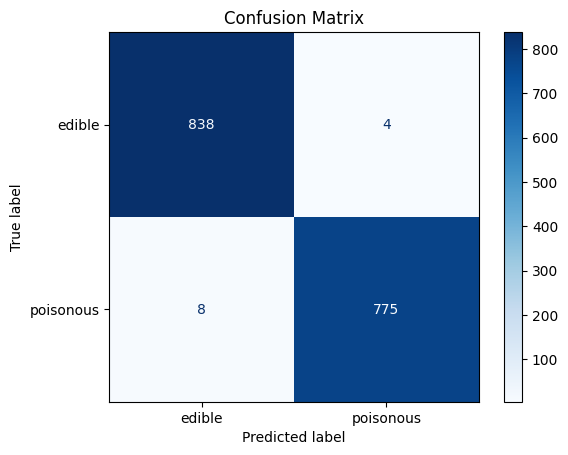

➤ Cecha 8
├── Wartość = 0
│   └── Klasa: 1
├── Wartość = 1
│   └── Klasa: 0
├── Wartość = 2
│   └── Cecha 4
│       ├── Wartość = 0
│       │   └── Klasa: 0
│       ├── Wartość = 1
│       │   └── Klasa: 1
│       ├── Wartość = 2
│       │   └── Klasa: 1
│       ├── Wartość = 3
│       │   └── Klasa: 0
│       └── Wartość = 5
│           └── Cecha 10
│               ├── Wartość = 0
│               │   └── Klasa: 1
│               ├── Wartość = 2
│               │   └── Klasa: 0
│               └── Wartość = 4
│                   └── Klasa: 0
├── Wartość = 3
│   └── Cecha 18
│       ├── Wartość = 0
│       │   └── Klasa: 0
│       ├── Wartość = 1
│       │   └── Klasa: 0
│       ├── Wartość = 2
│       │   └── Klasa: 1
│       └── Wartość = 4
│           └── Klasa: 1
├── Wartość = 4
│   └── Cecha 4
│       ├── Wartość = 0
│       │   └── Klasa: 0
│       ├── Wartość = 3
│       │   └── Klasa: 0
│       ├── Wartość = 5
│       │   └── Klasa: 0
│       └── Wartość = 6
│           └── Klasa: 1
├── Wartość = 5
│   └── Cecha 7
│       ├── Wartość = 0
│       │   └── Klasa: 0
│       └── Wartość = 1
│           └── Cecha 9
│               ├── Wartość = 0
│               │   └── Cecha 1
│               │       ├── Wartość = 0
│               │       │   └── Klasa: 0
│               │       ├── Wartość = 2
│               │       │   └── Klasa: 1
│               │       └── Wartość = 3
│               │           └── Klasa: 1
│               └── Wartość = 1
│                   └── Klasa: 0
├── Wartość = 6
│   └── Klasa: 0
├── Wartość = 7
│   └── Cecha 19
│       ├── Wartość = 1
│       │   └── Cecha 10
│       │       ├── Wartość = 0
│       │       │   └── Klasa: 1
│       │       └── Wartość = 4
│       │           └── Klasa: 0
│       ├── Wartość = 2
│       │   └── Cecha 9
│       │       ├── Wartość = 0
│       │       │   └── Cecha 10
│       │       │       ├── Wartość = 0
│       │       │       │   └── Klasa: 1
│       │       │       ├── Wartość = 2
│       │       │       │   └── Klasa: 1
│       │       │       └── Wartość = 3
│       │       │           └── Klasa: 0
│       │       └── Wartość = 1
│       │           └── Klasa: 0
│       ├── Wartość = 3
│       │   └── Cecha 4
│       │       ├── Wartość = 0
│       │       │   └── Klasa: 0
│       │       ├── Wartość = 1
│       │       │   └── Klasa: 1
│       │       ├── Wartość = 3
│       │       │   └── Klasa: 0
│       │       ├── Wartość = 5
│       │       │   └── Klasa: 0
│       │       └── Wartość = 6
│       │           └── Klasa: 1
│       ├── Wartość = 6
│       │   └── Klasa: 0
│       └── Wartość = 7
│           └── Klasa: 0
├── Wartość = 8
│   └── Klasa: 1
├── Wartość = 9
│   └── Cecha 4
│       ├── Wartość = 1
│       │   └── Klasa: 1
│       └── Wartość = 5
│           └── Klasa: 0
├── Wartość = 10
│   └── Cecha 4
│       ├── Wartość = 0
│       │   └── Klasa: 0
│       ├── Wartość = 2
│       │   └── Klasa: 1
│       ├── Wartość = 3
│       │   └── Klasa: 0
│       ├── Wartość = 4
│       │   └── Klasa: 1
│       ├── Wartość = 5
│       │   └── Cecha 2
│       │       ├── Wartość = 0
│       │       │   └── Cecha 10
│       │       │       ├── Wartość = 0
│       │       │       │   └── Klasa: 1
│       │       │       └── Wartość = 4
│       │       │           └── Klasa: 0
│       │       ├── Wartość = 1
│       │       │   └── Klasa: 0
│       │       ├── Wartość = 2
│       │       │   └── Klasa: 0
│       │       ├── Wartość = 3
│       │       │   └── Klasa: 0
│       │       ├── Wartość = 4
│       │       │   └── Cecha 11
│       │       │       ├── Wartość = 0
│       │       │       │   └── Klasa: 0
│       │       │       ├── Wartość = 1
│       │       │       │   └── Klasa: 1
│       │       │       ├── Wartość = 2
│       │       │       │   └── Klasa: 0
│       │       │       └── Wartość = 3
│       │       │           └── Klasa: 0
│       │       ├── Wartość = 5
│       │       │   └── Cecha 19
│       │       │       ├── Wartość = 5
│

In [129]:
data = fetch_openml(name="mushroom", version=1, as_frame=True)
X = data.data
y = data.target

X = X.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=3131, stratify=y
)
feature_order = list(range(X.shape[1]))
clf = CustomDecisionTreeClassifier(preference_list=feature_order[::-1],
                                   similarity_threshold=0.5,
                                   max_depth=4,
                                   min_samples_split=5,
                                   interactive=True,
                                   interactive_threshold=0.5)
clf.fit(X_train, y_train)
evaluate_model(clf, X_val, y_val, target_names=["edible", "poisonous"])
console = Console()
console.print(clf.to_rich())

# Testy i eksperymenty

## Zbiory danych

### Mushroom

#### 0) Podstawowy klasyfikator (brak preferencji)


#### a) Preferowane atrybuty o niewielkiej liczbie wartości

#### b) Preferowane atrybuty ustalone przez analizę danych

#### c) Preferowane atrybuty na podstawie kosztu uzyskania (w domyśle)

#### d) Unikanie atrybutów zawierających szum

#### e) Preferencje na podstawie logicznej istotności

#### Porównanie podejść

### Wine Quality

#### 0) Podstawowy klasyfikator (brak preferencji)


#### a) Preferowane atrybuty o niewielkiej liczbie wartości

#### b) Preferowane atrybuty ustalone przez analizę danych

#### c) Preferowane atrybuty na podstawie kosztu uzyskania (w domyśle)

#### d) Unikanie atrybutów zawierających szum

#### e) Preferencje na podstawie logicznej istotności

#### Porównanie podejść

### Apartment for Rent Classified

#### 0) Podstawowy klasyfikator (brak preferencji)


#### a) Preferowane atrybuty o niewielkiej liczbie wartości

#### b) Preferowane atrybuty ustalone przez analizę danych

#### c) Preferowane atrybuty na podstawie kosztu uzyskania (w domyśle)

#### d) Unikanie atrybutów zawierających szum

#### e) Preferencje na podstawie logicznej istotności

#### Porównanie podejść

### Appliances Energy Prediction

#### 0) Podstawowy klasyfikator (brak preferencji)


#### a) Preferowane atrybuty o niewielkiej liczbie wartości

#### b) Preferowane atrybuty ustalone przez analizę danych

#### c) Preferowane atrybuty na podstawie kosztu uzyskania (w domyśle)

#### d) Unikanie atrybutów zawierających szum

#### e) Preferencje na podstawie logicznej istotności

#### Porównanie podejść

## Porównanie wszystkich podejść

## Wnioski